In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
from copulas.multivariate import GaussianMultivariate
import numpy as np
from itertools import combinations
import importlib
import logging
import itertools
import ast
#import seaborn as sns


In [2]:
Data_folder = os.getcwd() + "/Data"

Data_folder

'/home/trapfishscott/Cambridge24.25/Energy_thesis/Data'

In [3]:
## Import pickls

car_df = pd.read_pickle(Data_folder + "/df_car.pkl")

In [5]:
def filter_df(df, weekday, year):

    df = df.copy()

    if "TravelWeekDay_B03ID" not in df.columns:
        raise ValueError(f"'TravelWeekDay_B03ID' not in DataFrame columns. DataFrame columns: {df.columns}")

    if weekday == 1:
        df = df[df["TravelWeekDay_B03ID"]==1]

    elif weekday == 2:
        df = df[df["TravelWeekDay_B03ID"]==2]

    else:
        raise ValueError(f"Weekday is {weekday}. Must be int(1) for weekday or int(2) for weekend ")
    
    
    if not (2002 <= year <= 2023):  # Correct range check
        raise ValueError(f"Year is {year}. Must be between 2002 and 2023.")

    logging.debug(f"Filtering where year={year}")

    df = df[df["TravelYear"] == year]

    return df

In [9]:
def return_copula(df, weekday, year, plots=False):

    df = df.copy()

    df = filter_df(df, weekday, year)

    if plots is True:
        # Work trips
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.title("A Histogram of Work Trip Start Times")
        plt.grid()
        work_home = df[df["TripType"] == (1,3)]
        home_work = df[df["TripType"] == (3,1)]
        plt.hist(work_home["TripStart"], bins=50, label="work->home")
        plt.hist(home_work["TripStart"], bins=50, label="home->work")
        plt.legend()
        
        
        plt.subplot(1,2,2)
        plt.title("A Histogram of Work Trip Distance Travelled")
        plt.grid()
        plt.hist(work_home["TripDisExSW"], bins=50, range=(0,60))

        plt.tight_layout()
        plt.show()

        # Home other trips
        plt.figure(figsize=(12,5))
        plt.subplot(1,2,1)
        plt.title("A Histogram of Home->Other Trip Start Times")
        plt.grid()
        home_other = df[df["TripType"] == (3,2)]
        plt.hist(home_other["TripStart"], bins=50)
            
        plt.subplot(1,2,2)
        plt.title("A Histogram of Home->Other trip Distance Travelled")
        plt.grid()
        plt.hist(home_other["TripDisExSW"], bins=50, range=(0,60))

        plt.tight_layout()
        plt.show()

    # Copulas
    logging.info("Using Copulas to generate multivariate distributions for continous variables")

    copulas = {}

    for combo in df["TripType"].unique():
        dist = GaussianMultivariate()
        to_copula = df[df["TripType"] == combo][["TripStart", "TripEnd", "TripDisExSW"]]
        # Dropping nans
        to_copula = to_copula.dropna(axis=0)
        logging.debug(to_copula.head())

        logging.debug("Taking 10000 randomly drawn samples or otherwise copula crashes")
        logging.debug(f"len of df before sampling: {len(to_copula)}")

        if len(to_copula) > 10000:
            to_copula = to_copula.sample(n=10000)

        logging.debug(f"len of df after sampling: {len(to_copula)}")   

        dist.fit(to_copula)
        copulas[f"copula_for_{combo}"] = dist
        logging.info(f"Copula for combo: {combo} is complete!")
             

    return copulas


In [ ]:
copulas = return_copula(car_df, 1, 2014)

/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize

In [8]:
type(copulas)

NoneType

In [4]:
# Trip type by travel day by journey sequence
x = car_df.groupby(["IndividualID", "TravDay", "JourSeq"])[["TripType"]].first()
x.head()
# Trip type by travel day by journey sequence
x = x.groupby(["IndividualID", "TravDay"])[["TripType"]].agg(list)

x = x.reset_index()

In [5]:
x["SumTrips"] = x["TripType"].apply(lambda x: len(x))

In [6]:
days = np.tile(np.arange(1,8), len(x["IndividualID"].unique()))

individuals = [i for i in x["IndividualID"].unique() for _ in range(7)]

new_df = pd.DataFrame({"IndividualID": individuals,
                       "TravDay": days })

merged_df = new_df.merge(x, on=["IndividualID", "TravDay"], how="left")

merged_df = merged_df.fillna(0)

merged_df["TripType"] = merged_df["TripType"].apply(lambda x: str(x))


In [7]:


print(f"There are {len(merged_df["TripType"].unique())} unique trip sequences.")


There are 5921 unique trip sequences.


In [8]:
merged_df

,IndividualID,TravDay,TripType,SumTrips
0,2002000001,1,0,0.0
1,2002000001,2,0,0.0
2,2002000001,3,0,0.0
3,2002000001,4,0,0.0
4,2002000001,5,0,0.0
...,...,...,...,...
1211583,2023017379,3,"[(3, 1), (1, 3), (3, 2), (2, 3)]",4.0
1211584,2023017379,4,"[(3, 2), (2, 3)]",2.0
1211585,2023017379,5,0,0.0
1211586,2023017379,6,"[(3, 1), (1, 3)]",2.0


In [9]:
# Finding if 1 trip, 2 trips, 3 trips ... per day. How many unique trip sequences in total + probabilities for different kinds of trip sequences

trip_probs = merged_df[["SumTrips", "TripType"]].groupby("SumTrips").value_counts(normalize=True).reset_index()

In [10]:
trip_probs["TripType"] = trip_probs["TripType"].apply(ast.literal_eval)

In [11]:
trip_probs

,SumTrips,TripType,proportion
0,0.0,0,1.000000
1,1.0,"[(3, 2)]",0.359880
2,1.0,"[(2, 3)]",0.358808
3,1.0,"[(3, 1)]",0.137585
4,1.0,"[(1, 3)]",0.094877
...,...,...,...
5916,20.0,"[(3, 2), (2, 3), (3, 2), (2, 2), (2, 3), (3, 2...",0.333333
5917,21.0,"[(3, 2), (2, 2), (2, 2), (2, 2), (2, 2), (2, 2...",0.333333
5918,21.0,"[(3, 2), (2, 2), (2, 2), (2, 2), (2, 3), (3, 2...",0.333333
5919,21.0,"[(3, 2), (2, 3), (3, 2), (2, 2), (2, 2), (2, 3...",0.333333


In [12]:
pop_seq_weights = {}

for trip_length in trip_probs.SumTrips.unique():
    by_trip_length = trip_probs[trip_probs["SumTrips"] == trip_length]
    print(by_trip_length.head())
    population = list(by_trip_length["TripType"])
    weights = list(by_trip_length["proportion"])
    #print(population[0])
    #print(weights[0])
    pop_seq_weights[f"trip_length_{int(trip_length)}"] = [population, weights]



   SumTrips TripType  proportion
0       0.0        0         1.0
   SumTrips  TripType  proportion
1       1.0  [(3, 2)]    0.359880
2       1.0  [(2, 3)]    0.358808
3       1.0  [(3, 1)]    0.137585
4       1.0  [(1, 3)]    0.094877
5       1.0  [(2, 2)]    0.043675
    SumTrips          TripType  proportion
8        2.0  [(3, 2), (2, 3)]    0.583721
9        2.0  [(3, 1), (1, 3)]    0.357063
10       2.0  [(2, 2), (2, 2)]    0.013905
11       2.0  [(1, 3), (3, 1)]    0.013148
12       2.0  [(2, 2), (2, 3)]    0.007467
    SumTrips                  TripType  proportion
50       3.0  [(3, 2), (2, 2), (2, 3)]    0.452526
51       3.0  [(3, 1), (1, 2), (2, 3)]    0.208922
52       3.0  [(3, 2), (2, 1), (1, 3)]    0.091577
53       3.0  [(3, 2), (2, 3), (3, 2)]    0.040018
54       3.0  [(2, 3), (3, 2), (2, 3)]    0.037630
     SumTrips                          TripType  proportion
206       4.0  [(3, 2), (2, 3), (3, 2), (2, 3)]    0.480470
207       4.0  [(3, 1), (1, 3), (3, 2), (2, 3)

In [13]:
pop_seq_weights["trip_length_2"][1]

[0.5837208681750808,
 0.35706332282925907,
 0.013905162522045213,
 0.0131482869625759,
 0.007466868500149192,
 0.00654745876605025,
 0.004451495678289073,
 0.0030056692890464095,
 0.0021978501823051227,
 0.002040167774082349,
 0.001855800650621875,
 0.0009533720989469241,
 0.0009048544348783784,
 0.0006113225672636765,
 0.0005167131223300122,
 0.00038814131254836604,
 0.00026684715237700166,
 0.00026442126917357436,
 0.00020134830588446488,
 5.579531367882762e-05,
 4.8517664068545755e-05,
 4.8517664068545755e-05,
 4.366589766169118e-05,
 3.638824805140932e-05,
 3.396236484798203e-05,
 3.153648164455474e-05,
 2.9110598441127454e-05,
 2.6684715237700166e-05,
 2.4258832034272877e-05,
 1.9407065627418304e-05,
 1.9407065627418304e-05,
 9.703532813709152e-06,
 9.703532813709152e-06,
 9.703532813709152e-06,
 9.703532813709152e-06,
 7.2776496102818635e-06,
 7.2776496102818635e-06,
 4.851766406854576e-06,
 4.851766406854576e-06,
 4.851766406854576e-06,
 2.425883203427288e-06,
 2.425883203427288

In [14]:
for i,(k,v) in enumerate(pop_seq_weights.items()):
    if i <=4:
        print(k, v[0][0], v[1][0])

trip_length_0 0 1.0
trip_length_1 [(3, 2)] 0.3598797699947726
trip_length_2 [(3, 2), (2, 3)] 0.5837208681750808
trip_length_3 [(3, 2), (2, 2), (2, 3)] 0.45252596816400226
trip_length_4 [(3, 2), (2, 3), (3, 2), (2, 3)] 0.4804698049806865


In [15]:
r = car_df["TripType"].value_counts(normalize=True).reset_index()

#1 work
#2 other
#3 home

mapping = {(2,3): "other->home",
           (3,2): "home->other",
           (3,1): "home->work",
           (2,2): "other->other",
           (1,3): "work->home",
           (1,2): "work->other",
           (2,1): "other->work"}

r["TripType_mapped"] = r["TripType"].map(mapping)

r

,TripType,proportion,TripType_mapped
0,"(2, 3)",0.324670,other->home
1,"(3, 2)",0.318645,home->other
2,"(3, 1)",0.106809,home->work
3,"(2, 2)",0.104834,other->other
4,"(1, 3)",0.099178,work->home
5,"(1, 2)",0.026362,work->other
6,"(2, 1)",0.019503,other->work


(array([1.5700e+02, 8.2000e+01, 4.3000e+01, 4.4000e+01, 4.9000e+01,
        7.2000e+01, 1.1700e+02, 3.2400e+02, 6.6800e+02, 1.9110e+03,
        4.5700e+03, 1.0510e+04, 2.5534e+04, 4.8286e+04, 4.3246e+04,
        3.6466e+04, 4.1277e+04, 3.4896e+04, 2.3870e+04, 2.4541e+04,
        1.9270e+04, 2.1533e+04, 2.3057e+04, 2.9038e+04, 2.7420e+04,
        2.0470e+04, 1.9116e+04, 1.7065e+04, 2.3434e+04, 2.1949e+04,
        2.8797e+04, 1.5818e+04, 9.8420e+03, 5.3600e+03, 3.0230e+03,
        1.9120e+03, 1.0180e+03, 6.2200e+02, 7.0000e+01, 7.0000e+00,
        1.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   0. ,   37.8,   75.6,  113.4,  151.2,  189. ,  226.8,  264.6,
         302.4,  340.2,  378. ,  415.8,  453.6,  491.4,  529.2,  567. ,
         604.8,  642.6,  680.4,  718.2,  756. ,  793.8,  831.6,  869.4,
         907.2,  945. ,  982.8, 1020.6, 1058.4, 1096.2, 1134. , 1171.8,
        1209.6, 1247.4, 1285.2

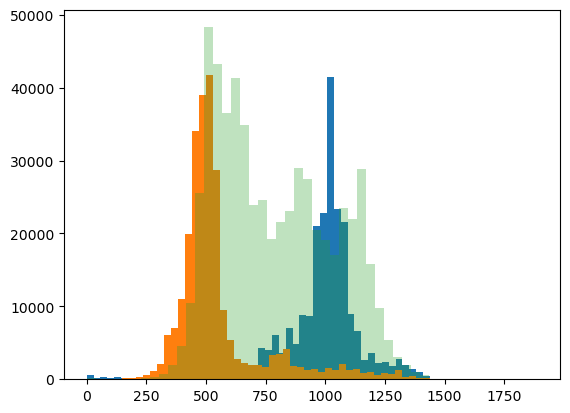

In [16]:
car_df_wd = car_df[car_df["TravelWeekDay_B03ID"]==1]


x = car_df_wd[car_df_wd["TripType"] == (1,3)]
y = car_df_wd[car_df_wd["TripType"] == (3,1)]
z = car_df_wd[car_df_wd["TripType"] == (3,2)]

plt.hist(x["TripStart"], bins=50)
plt.hist(y["TripEnd"], bins=50)
plt.hist(z["TripEnd"], bins=50, alpha=0.3)

(array([115632., 123554.,  89566.,  49463.,  39051.,  43039.,  19720.,
         11919.,  14888.,   7058.,  13756.,   5158.,   7190.,   3724.,
          2925.,   4598.,   3897.,   1525.,   1842.,   1366.,   3315.,
          1190.,    982.,    963.,    603.,   2132.,    754.,    564.,
           529.,   1054.,    901.,    600.,    321.,   1067.,    305.,
           731.,    311.,    718.,    281.,    285.,    513.,    693.,
           216.,    273.,    229.,    532.,    205.,    188.,    207.,
           634.]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ,
        13.2, 14.4, 15.6, 16.8, 18. , 19.2, 20.4, 21.6, 22.8, 24. , 25.2,
        26.4, 27.6, 28.8, 30. , 31.2, 32.4, 33.6, 34.8, 36. , 37.2, 38.4,
        39.6, 40.8, 42. , 43.2, 44.4, 45.6, 46.8, 48. , 49.2, 50.4, 51.6,
        52.8, 54. , 55.2, 56.4, 57.6, 58.8, 60. ]),
 <BarContainer object of 50 artists>)

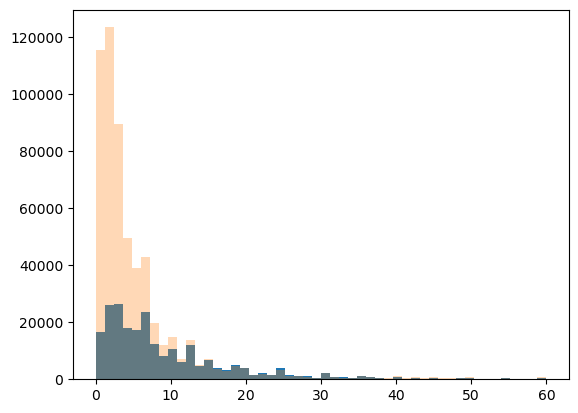

In [17]:
car_df_wd = car_df[car_df["TravelWeekDay_B03ID"]==1]


x = car_df_wd[car_df_wd["TripType"] == (1,3)]
y = car_df_wd[car_df_wd["TripType"] == (3,1)]
z = car_df_wd[car_df_wd["TripType"] == (3,2)]

plt.hist(x["TripDisExSW"], bins=50, range=(0,60))
#plt.hist(y["TripEnd"], bins=50)
plt.hist(z["TripDisExSW"], bins=50, alpha=0.3, range=(0,60))

(array([1.3700e+02, 7.6000e+01, 4.6000e+01, 4.9000e+01, 2.0000e+01,
        2.5000e+01, 2.9000e+01, 2.6000e+01, 3.9000e+01, 8.9000e+01,
        1.4900e+02, 3.9000e+02, 5.8000e+02, 1.5460e+03, 2.0700e+03,
        4.2040e+03, 5.5720e+03, 9.7400e+03, 1.3236e+04, 1.8131e+04,
        1.5806e+04, 1.6545e+04, 1.3494e+04, 1.2103e+04, 9.9450e+03,
        1.1091e+04, 9.5320e+03, 1.3701e+04, 8.4090e+03, 8.4630e+03,
        5.7610e+03, 6.5160e+03, 4.7550e+03, 4.8740e+03, 4.8450e+03,
        5.5560e+03, 5.6570e+03, 4.5910e+03, 3.4490e+03, 2.1780e+03,
        1.5220e+03, 8.9000e+02, 7.3100e+02, 4.7100e+02, 3.6000e+02,
        2.5400e+02, 6.4000e+01, 1.0000e+00, 1.0000e+00, 3.0000e+00]),
 array([   0. ,   31.1,   62.2,   93.3,  124.4,  155.5,  186.6,  217.7,
         248.8,  279.9,  311. ,  342.1,  373.2,  404.3,  435.4,  466.5,
         497.6,  528.7,  559.8,  590.9,  622. ,  653.1,  684.2,  715.3,
         746.4,  777.5,  808.6,  839.7,  870.8,  901.9,  933. ,  964.1,
         995.2, 1026.3, 1057.4

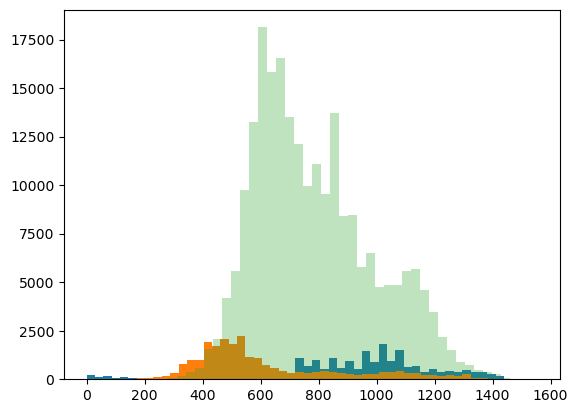

In [18]:
car_df_we = car_df[car_df["TravelWeekDay_B03ID"]==2]


x = car_df_we[car_df_we["TripType"] == (1,3)]
y = car_df_we[car_df_we["TripType"] == (3,1)]
z = car_df_we[car_df_we["TripType"] == (3,2)]

plt.hist(x["TripStart"], bins=50)
plt.hist(y["TripEnd"], bins=50)
plt.hist(z["TripEnd"], bins=50, alpha=0.3)

In [19]:
car_df

,DayID,IndividualID,TravDay,JourSeq,TripStart,TripEnd,TripDisExSW,TravelYear,TravelWeekDay_B03ID,TripType
0,2014050554,2014007801,7,1,420.0,425.0,2.0,2014,1,"(3, 1)"
1,2014050554,2014007801,7,3,1080.0,1125.0,10.0,2014,1,"(3, 2)"
2,2014050561,2014007802,7,1,360.0,395.0,13.0,2014,1,"(3, 1)"
3,2014050561,2014007802,7,3,1200.0,1220.0,5.0,2014,1,"(3, 2)"
4,2014050567,2014007803,6,2,1140.0,1155.0,3.5,2014,1,"(2, 3)"
...,...,...,...,...,...,...,...,...,...,...
5342915,2023101345,2023017037,6,1,565.0,580.0,9.3,2024,2,"(3, 2)"
5342916,2023101345,2023017037,6,2,590.0,610.0,7.0,2024,2,"(2, 2)"
5342917,2023101345,2023017037,6,3,620.0,655.0,16.0,2024,2,"(2, 3)"
5342918,2023101346,2023017037,7,1,710.0,750.0,20.0,2024,2,"(3, 2)"


In [23]:
## Designing a copula

test_df = car_df[car_df["TravelYear"]==2014]
test_df = test_df[test_df["TravelWeekDay_B03ID"]==1]

copulas = {}

for combo in test_df["TripType"].unique():
    dist = GaussianMultivariate()
    to_copula = test_df[test_df["TripType"] == combo][["TripStart", "TripEnd", "TripDisExSW"]]
    # Dropping nans
    to_copula = to_copula.dropna(axis=0)
    print(to_copula.head())
    print(f"len of df before sampling: {len(to_copula)}")

    if len(to_copula) > 10000:
        to_copula = to_copula.sample(n=10000)

    print(f"len of df after sampling: {len(to_copula)}")    
    

    
    dist.fit(to_copula)
    copulas[f"copula_for_{combo}"] = dist
    print(f"combo: {combo} is complete!")
    
    print("")





     TripStart  TripEnd  TripDisExSW
0        420.0    425.0          2.0
2        360.0    395.0         13.0
65       503.0    512.0          3.0
116      465.0    490.0         14.7
153      383.0    400.0          7.0
len of df before sampling: 10179
len of df after sampling: 10000


/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize

combo: (3, 1) is complete!

    TripStart  TripEnd  TripDisExSW
1      1080.0   1125.0         10.0
3      1200.0   1220.0          5.0
24      630.0    659.0         10.0
26      735.0    765.0         20.0
27      495.0    535.0         18.0
len of df before sampling: 25614
len of df after sampling: 10000


/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


combo: (3, 2) is complete!

    TripStart  TripEnd  TripDisExSW
4      1140.0   1155.0          3.5
5      1150.0   1165.0          3.5
25     1052.0   1084.0         22.0
52      930.0   1050.0         97.0
66      594.0    600.0          1.0
len of df before sampling: 25651
len of df after sampling: 10000


/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


combo: (2, 3) is complete!

     TripStart  TripEnd  TripDisExSW
50      1050.0   1065.0          3.0
51      1080.0   1095.0          3.0
53      1080.0   1140.0         34.0
157     1335.0   1355.0          8.0
220     1030.0   1080.0         16.0
len of df before sampling: 9351
len of df after sampling: 9351


/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize

combo: (1, 3) is complete!

      TripStart  TripEnd  TripDisExSW
64       1050.0   1065.0          4.0
335      1110.0   1120.0          0.5
684       515.0    620.0         68.8
1448      840.0    850.0          3.0
1804     1015.0   1022.0          3.0
len of df before sampling: 2631
len of df after sampling: 2631


/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


combo: (1, 2) is complete!

     TripStart  TripEnd  TripDisExSW
117     1050.0   1075.0          7.9
151      615.0    619.0          1.0
512      636.0    641.0          1.0
519     1045.0   1060.0          2.5
604     1140.0   1150.0          1.0
len of df before sampling: 8295
len of df after sampling: 8295


/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


combo: (2, 2) is complete!

      TripStart  TripEnd  TripDisExSW
276       480.0    495.0          4.0
1030      480.0    495.0          4.0
1128      505.0    540.0         11.4
1129      510.0    531.0         11.4
1803      505.0    511.0          3.0
len of df before sampling: 1989
len of df after sampling: 1989


/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:785: RuntimeWarning: invalid value encountered in sqrt
  sk = 2*(b-a)*np.sqrt(a + b + 1) / (a + b + 2) / np.sqrt(a*b)
/home/trapfishscott/miniconda3/envs/EnergyThesis/lib/python3.13/site-packages/scipy/stats/_continuous_distns.py:790: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))


combo: (2, 1) is complete!



In [29]:
r = copulas["copula_for_(1, 3)"].sample(1000)

In [114]:
copulas

{'copula_for_(3, 1)': GaussianMultivariate(),
 'copula_for_(3, 2)': GaussianMultivariate(),
 'copula_for_(2, 3)': GaussianMultivariate(),
 'copula_for_(1, 3)': GaussianMultivariate(),
 'copula_for_(1, 2)': GaussianMultivariate(),
 'copula_for_(2, 2)': GaussianMultivariate(),
 'copula_for_(2, 1)': GaussianMultivariate()}

(array([  8.,   3.,  10.,  14.,  25., 102., 290., 425.,  80.,  43.]),
 array([  14.75559378,  156.95919802,  299.16280225,  441.36640648,
         583.57001071,  725.77361494,  867.97721917, 1010.18082341,
        1152.38442764, 1294.58803187, 1436.7916361 ]),
 <BarContainer object of 10 artists>)

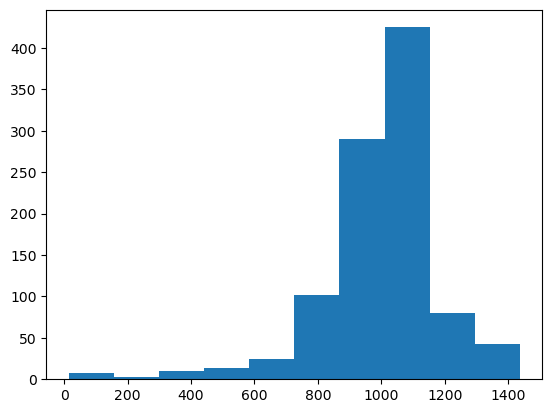

In [30]:
plt.hist(r["TripStart"])

In [104]:


while np.all(ar1 < 0):
    ar1 = np.round(copulas["copula_for_(1, 3)"].sample(1).to_numpy(), 2)
    print(ar1)

In [146]:
def gen_cont_seq(row, copula_dict):
    print(row)
    
    if isinstance(row["trip_seqs"], list):

        start_end_dis = []

        for i,seq in enumerate(row["trip_seqs"]):

            if i == 0:
                print(f"i: {i}: seq: {seq}")
                while True:
                    copula_samp = np.round(copula_dict[f"copula_for_{seq}"].sample(1).to_numpy(), 2).flatten()
                    print(f"copula_samp: {copula_samp}")
                    # All entries are negative and trip end is greater than trip start
                    if np.all(copula_samp>0) and (copula_samp[1] > copula_samp[0]):
                        break

                start_end_dis.append(copula_samp)

                print(f"current output: {start_end_dis}")

            else:
                while True:
                    copula_samp = np.round(copula_dict[f"copula_for_{seq}"].sample(1).to_numpy(), 2).flatten()
                    print(f"copula_samp: {copula_samp}")
                    # All entries are negative and trip end is greater than trip start and next trip trip start is greater than last trips trip end
                    if np.all(copula_samp>0) and (copula_samp[1] > copula_samp[0]) and (copula_samp[0] > start_end_dis[-1][1]):
                        break

                start_end_dis.append(copula_samp)

                print(f"current output: {start_end_dis}")

        return start_end_dis
    
    else:
        return 0






In [110]:


import importlib
import Mobility_simulator  # Import the script once

importlib.reload(Mobility_simulator)  # Reload the script after changes


<module 'Mobility_simulator' from '/home/trapfishscott/Cambridge24.25/Energy_thesis/Mobility_simulator.py'>

In [ ]:
m = Mobility_simulator.MobilitySimulator(nts_df=car_df, year=2021)

m.simulate()


test = m.mobility_schedule


In [117]:
test

,Year,we_wd,num_trips,trip_seqs
0,2021,1,0,0
1,2021,2,2,"[(3, 1), (1, 3)]"
2,2021,2,1,"[(2, 3)]"
3,2021,1,2,"[(3, 2), (2, 3)]"
4,2021,1,0,0
...,...,...,...,...
361,2021,1,0,0
362,2021,1,2,"[(3, 2), (2, 3)]"
363,2021,1,0,0
364,2021,1,0,0


In [148]:
test.apply(lambda row: gen_cont_seq(row, copula_dict=copulas), axis=1)


Year         2021
we_wd           1
num_trips       0
trip_seqs       0
Name: 0, dtype: object
Year                     2021
we_wd                       2
num_trips                   2
trip_seqs    [(3, 1), (1, 3)]
Name: 1, dtype: object
i: 0: seq: (3, 1)
copula_samp: [524.97 581.    13.96]
current output: [array([524.97, 581.  ,  13.96])]
copula_samp: [1064.69 1118.12    5.52]
current output: [array([524.97, 581.  ,  13.96]), array([1064.69, 1118.12,    5.52])]
Year             2021
we_wd               2
num_trips           1
trip_seqs    [(2, 3)]
Name: 2, dtype: object
i: 0: seq: (2, 3)
copula_samp: [674.28 775.88   4.77]
current output: [array([674.28, 775.88,   4.77])]
Year                     2021
we_wd                       1
num_trips                   2
trip_seqs    [(3, 2), (2, 3)]
Name: 3, dtype: object
i: 0: seq: (3, 2)
copula_samp: [6.8280e+02 6.4323e+02 1.7000e-01]
copula_samp: [6.9526e+02 7.8180e+02 6.0000e-01]
current output: [array([6.9526e+02, 7.8180e+02, 6.0000e-01])]

KeyboardInterrupt: 

In [124]:
test["trip_seqs"]

0                     0
1      [(3, 1), (1, 3)]
2              [(2, 3)]
3      [(3, 2), (2, 3)]
4                     0
             ...       
361                   0
362    [(3, 2), (2, 3)]
363                   0
364                   0
365    [(3, 1), (1, 3)]
Name: trip_seqs, Length: 366, dtype: object